##**Diana Kim, Zhanibek Meiramkan, Tomiris Murzagali CS - 2120**

# **General Information and ETL**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyspark
from pyspark import SparkConf, SparkContext
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
spark = SparkSession.builder.appName("police_shootings").getOrCreate()
dataset_path = "/content/drive/MyDrive/shootings.csv"
df = pd.read_csv(dataset_path)

In [ ]:
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,Asian,Shelton,WA,True,attack,Not fleeing,False,Guns
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,White,Aloha,OR,False,attack,Not fleeing,False,Guns
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,Hispanic,Wichita,KS,False,other,Not fleeing,False,Unarmed
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,White,San Francisco,CA,True,attack,Not fleeing,False,Other unusual objects
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,Hispanic,Evans,CO,False,attack,Not fleeing,False,Piercing objects


**Checking the data types**

In [ ]:
df.dtypes

id                           int64
name                        object
date                        object
manner_of_death             object
armed                       object
age                        float64
gender                      object
race                        object
city                        object
state                       object
signs_of_mental_illness       bool
threat_level                object
flee                        object
body_camera                   bool
arms_category               object
dtype: object

**Converting the "Date" column from String to Date Format**

In [ ]:
df['date']=pd.to_datetime(df['date'])
df['state'] = df['state'].astype('string')

df.dtypes

id                                  int64
name                               object
date                       datetime64[ns]
manner_of_death                    object
armed                              object
age                               float64
gender                             object
race                               object
city                               object
state                              string
signs_of_mental_illness              bool
threat_level                       object
flee                               object
body_camera                          bool
arms_category                      object
dtype: object

In [ ]:
df.isnull().sum()

id                         0
name                       0
date                       0
manner_of_death            0
armed                      0
age                        0
gender                     0
race                       0
city                       0
state                      0
signs_of_mental_illness    0
threat_level               0
flee                       0
body_camera                0
arms_category              0
dtype: int64

# **Number of people killed in police shootings and the average age:**

In [ ]:
People_death = df['name'].nunique()
Death_avg_age = np.average(df['age'])

print('{} People with an average age of {} have been killed in Shooting'.format(People_death, round(Death_avg_age, 2)))


4851 People with an average age of 36.55 have been killed in Shooting


# **Shooting deaths by Race in each year:**

In [ ]:
df['year'] = pd.to_datetime(df['date']).dt.year
race_counts_year = df.pivot_table(index='race', columns='year', aggfunc='size', fill_value=0, margins=False)
display(race_counts_year)

year,2015,2016,2017,2018,2019,2020
race,,,,,,
Asian,14,15,16,21,19,8
Black,258,234,224,229,250,103
Hispanic,172,160,179,165,163,63
Native,9,16,22,15,13,3
Other,15,11,6,4,9,3
White,497,468,459,454,404,194


# **Count of deaths by Age and Top 5 ages with the highest death rate:**

In [ ]:
age_counts = df['age'].value_counts().reset_index().rename(columns={'index': 'Age', 'age': 'Counts'})
display(age_counts)
top_5_ages = age_counts.head(5)
print('\nTop 5 ages with the highest death rate::')
print(top_5_ages)


,Age,Counts
0,25.0,176
1,31.0,174
2,27.0,165
3,33.0,164
4,29.0,160
...,...,...
71,13.0,1
72,91.0,1
73,79.0,1
74,78.0,1



Top 5 ages with the highest death rate::
    Age  Counts
0  25.0     176
1  31.0     174
2  27.0     165
3  33.0     164
4  29.0     160


#**Overall number of shooting deaths by Gender and gender wise death counts over the years**

In [ ]:
overall_gender_counts = df['gender'].value_counts().reset_index().rename(columns={'index': 'Gender', 'gender': 'Counts'})
print('Overall Number of Shooting Deaths by Gender:')
display(overall_gender_counts)

gender_counts_year = df.groupby(['gender', 'year']).size().reset_index(name='Counts')
print('\nGender wise Death Counts over the Years:')
display(gender_counts_year)


Overall Number of Shooting Deaths by Gender:


,Gender,Counts
0,M,4673
1,F,222



Gender wise Death Counts over the Years:


,gender,year,Counts
0,F,2015,41
1,F,2016,38
2,F,2017,40
3,F,2018,48
4,F,2019,40
5,F,2020,15
6,M,2015,924
7,M,2016,866
8,M,2017,866
9,M,2018,840


# **Cities with the highest shooting deaths over the years**

In [ ]:
import sqlite3
conn = sqlite3.connect("/content/drive/MyDrive/shootings.db")
df.to_sql("shootings", conn, if_exists="replace", index=False)
query = """
        SELECT city, COUNT(*) as num_incidents
        FROM shootings
        GROUP BY city
        ORDER BY num_incidents DESC
        LIMIT 10
        """

most_dangerous_cities = pd.read_sql(query, conn)

print(most_dangerous_cities)
conn.close()

           city  num_incidents
0   Los Angeles             78
1       Phoenix             66
2       Houston             51
3     Las Vegas             41
4   San Antonio             40
5       Chicago             38
6      Columbus             36
7   Albuquerque             32
8  Jacksonville             31
9     St. Louis             30


# **The most 20 dangerous states**

In [ ]:
from pyspark import SparkConf, SparkContext
sc = SparkContext.getOrCreate()

rdd = sc.textFile("/content/drive/MyDrive/shootings.csv")

header = rdd.first()
rdd = rdd.filter(lambda row: row != header)
states_rdd = rdd.map(lambda row: row.split(",")[9])

state_counts_rdd = states_rdd.map(lambda state: (state, 1)).reduceByKey(lambda x, y: x + y)
most_dangerous_states_rdd = state_counts_rdd.takeOrdered(20, key=lambda x: -x[1])

for state, count in most_dangerous_states_rdd:
    print(state, ":", count)

sc.stop()

CA : 701
TX : 425
FL : 323
AZ : 221
CO : 168
GA : 160
OK : 150
NC : 148
OH : 146
WA : 126
TN : 125
MO : 124
LA : 101
IL : 99
AL : 95
PA : 94
NM : 93
VA : 92
IN : 91
NY : 90


#**Is mental sickness a reason for attacks by Victims?**

In [ ]:
mental_illness_threat = pd.crosstab(df['signs_of_mental_illness'], df['threat_level'], margins=True, margins_name='Total')
print('Mental Illness Signs vs Threat Level:')
print('\n')
display(mental_illness_threat_crosstab)

percentage_mental_illness_threat = mental_illness_threat_crosstab.div(mental_illness_threat_crosstab['Total'], axis=0) * 100
print('\n')
print('\nPercentage of Attacks with Signs of Mental Illness by Threat Level')
print('\n')
display(percentage_mental_illness_threat)


Mental Illness Signs vs Threat Level:




threat_level,attack,other,undetermined,Total
signs_of_mental_illness,,,,
False,2494,1124,174,3792
True,666,404,33,1103
Total,3160,1528,207,4895





Percentage of Attacks with Signs of Mental Illness by Threat Level




threat_level,attack,other,undetermined,Total
signs_of_mental_illness,,,,
False,65.770042,29.641350,4.588608,100.0
True,60.380780,36.627380,2.991840,100.0
Total,64.555669,31.215526,4.228805,100.0


# **Statistics of Threat Types**

In [ ]:
threat_level=df.threat_level.value_counts()
threat_level

attack          3160
other           1528
undetermined     207
Name: threat_level, dtype: int64

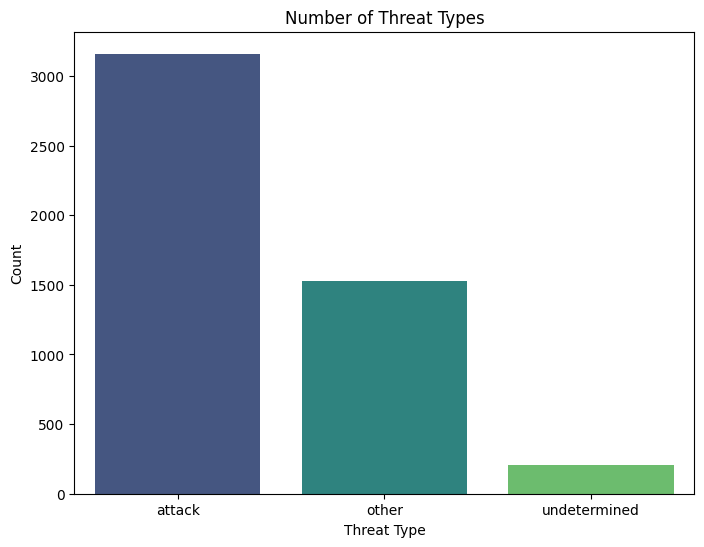

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=threat_level.index, y=threat_level.values, hue=threat_level.index, palette="viridis", legend=False)
plt.title('Number of Threat Types')
plt.xlabel('Threat Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

#**Statistics of Flee Types**


In [ ]:
flee = df['flee'].value_counts()
flee

Not fleeing    3073
Car             820
Foot            642
Other           360
Name: flee, dtype: int64

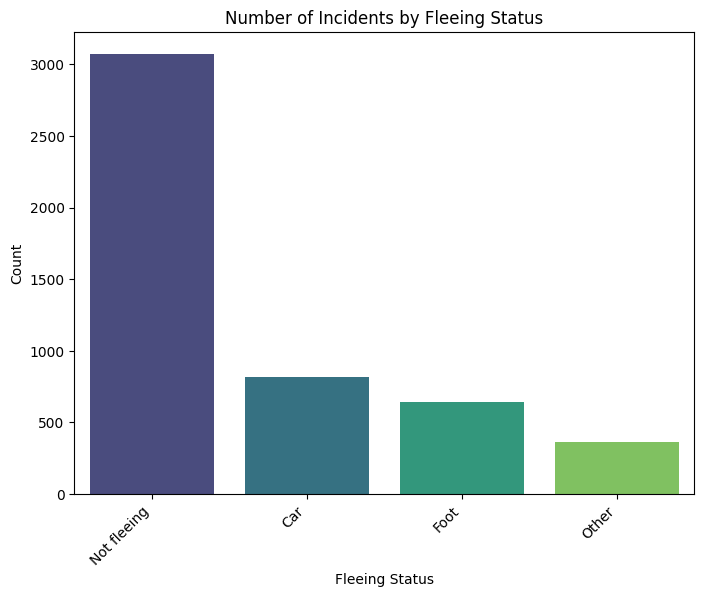

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=flee.index, y=flee.values, hue=flee.index, palette="viridis", legend=False)
plt.title('Number of Incidents by Fleeing Status')
plt.xlabel('Fleeing Status')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()